<a href="https://colab.research.google.com/github/tophercollins/handwritten-character-recognition/blob/main/custom_handwritten_character_recognition_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom EMNIST Handwritten Character Recognition

## Structure
0. Instruction
1. Setup
2. Load Data
3. Pre-process Data
4. View Samples
5. Model Experiments
6. Model (Final Selection)
7. Results

# 0. **Instruction**
* *You can add/remove Target and Strikethrough Characters from the 2 lists below.*
* *You can switch between the Regular and Balanced EMNIST data
  * Regular: Maximum amount of training data but classes are imbalanced
  * Balanced: MUCH less training data but classes are balanced
* *If the Strikethrough Characters are confusing the model, you can set STRIKETHROUGH_ON = False*
* *You can run the experiment models by setting RUN_EXPERIMENTS = True*

In [1]:
### Set Target and Strikethrough Characters

TARGET_CLASSES = ['0','1','2','3','4','5','C','M','V','X']
STRIKETHROUGH_CLASSES = ['0_s','1_s','2_s','3_s','4_s','5_s','V_s']

### Regular/Full Emnist or Balanced Emnist

EMNIST_PATH = 'emnist'
# EMNIST_PATH = 'emnist/balanced'

### Set Strikethrough Characters On/Off (True/False)

STRIKETHROUGH_ON = True

### Run Experiments On/Off (True/False)

RUN_EXPERIMENTS = False

# 1. Setup
* Setup
* Import Packages and Dependencies
* Create Helper Functions

## Classes/Labels

In [2]:
### Classes
if STRIKETHROUGH_ON:
  CLASSES = TARGET_CLASSES + STRIKETHROUGH_CLASSES
else:
  CLASSES = TARGET_CLASSES

NUM_CLASSES = len(CLASSES)

print(f'Number of Classes: {NUM_CLASSES}')
print(f'Classes: {CLASSES}')

# Character to Label Mapping
ORIGINAL_LABEL_MAPPING = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
                 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18,
                 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27,
                 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35}

# Labels
ORIGINAL_LABELS = [ORIGINAL_LABEL_MAPPING[char] for char in TARGET_CLASSES]
ORIGINAL_TO_NEW = {char: index for index, char in enumerate(ORIGINAL_LABELS)}
NEW_LABEL_MAPPING = {index: char for index, char in enumerate(CLASSES)}

print(f'Original Labels: {ORIGINAL_LABELS}')
print(f'Original to New: {ORIGINAL_TO_NEW}')
print(f'New Label Mapping: {NEW_LABEL_MAPPING}')

Number of Classes: 17
Classes: ['0', '1', '2', '3', '4', '5', 'C', 'M', 'V', 'X', '0_s', '1_s', '2_s', '3_s', '4_s', '5_s', 'V_s']
Original Labels: [0, 1, 2, 3, 4, 5, 12, 22, 31, 33]
Original to New: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 12: 6, 22: 7, 31: 8, 33: 9}
New Label Mapping: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: 'C', 7: 'M', 8: 'V', 9: 'X', 10: '0_s', 11: '1_s', 12: '2_s', 13: '3_s', 14: '4_s', 15: '5_s', 16: 'V_s'}


## Packages/Dependencies

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

## Helper Functions

In [4]:
from re import I
# View Image
def view_image(image, label=None):
    # Process image
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image, k=1)
    # Show image
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    if label == None:
      pass
    else:
      plt.title(f'Label: {CLASSES[label]}')
    # Remove the x and y ticks
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    # Remove the tick labels as well
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.show()

# Display Grid
def display_grid(indexes, images, labels, num_cols=6):
  num_images = len(indexes)
  num_rows = (num_images + num_cols - 1) // num_cols
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))

  for i, index in enumerate(indexes):
    row = i // num_cols
    col = i % num_cols
    image = images[index]
    label = labels[index]
    # Process image
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image, k=1)
    # Show image
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'Label: {CLASSES[label]}')
    axes[row, col].axis('off')
  plt.tight_layout()
  plt.show();

# Add Strikethrough
def add_strikethrough(image):
    """
    Adds a consistent strike-through line in one of four optional directions (horizontal, vertical, diagonal 1, diagonal 2) to the input image.

    :param image: The input image as a numpy array.
    :return: The image with a strike-through line added.
    """
    height, width = image.shape[:2]
    strikethrough_image = image.copy()

    # Choose a random direction for the strike-through line
    direction = random.choice(['horizontal', 'diagonal1']) # Optionally add 'vertical' and/or 'diagonal2'

    thickness = 2

    if direction == 'vertical':
        y = height // 2
        start_point = (0, y)
        end_point = (width, y)
    elif direction == 'horizontal':
        x = width // 2
        start_point = (x, 0)
        end_point = (x, height)
    elif direction == 'diagonal1':
        start_point = (0, height)
        end_point = (width, 0)
    elif direction == 'diagonal2':
        start_point = (0, 0)
        end_point = (width, height)


    # Draw the line
    cv2.line(strikethrough_image, start_point, end_point, (255,), thickness)

    return strikethrough_image

# Strikethrough Image Arrays
def strikethrough_image_arrays(image_arrays, image_labels):
    """
    Processes a list of image arrays, adds a consistent strike-through line to each, and returns the modified arrays.

    :param image_arrays: List of input images as numpy arrays.
    :return: Tuple of processed image arrays and labels.
    """
    processed_images = []
    processed_labels = []

    reverse_strikethrough_classes = {}
    count = 0
    for char in STRIKETHROUGH_CLASSES:
        reverse_strikethrough_classes[char] = len(TARGET_CLASSES) + count
        count += 1


    for image, label in zip(image_arrays, image_labels):
      if CLASSES[label]+'_s' in STRIKETHROUGH_CLASSES:
        processed_image = add_strikethrough(image)
        processed_images.append(processed_image)
        processed_labels.append(reverse_strikethrough_classes[CLASSES[label]+'_s'])

    return processed_images, processed_labels

# Plot Loss Curve
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Make Confusion Matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


# Test Image
def test_image(model, image, label=None, testset=False):
  if testset == False:
    # Process image
    image = np.expand_dims(image, axis=2)
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image, k=1)
    image = tf.image.resize(image, (28, 28))
    image = image / 255.0
  # Reshape image
  image = np.expand_dims(image, axis=0)
  # Get prediction
  prediction = model.predict(image)
  # Get index with highest probability
  predicted_index = np.argmax(prediction)
  # Get prediction probability
  predicted_probability = prediction[0][predicted_index]
  # Show image
  plt.figure(figsize=(2, 2))
  plt.imshow(image[0], cmap='gray')
  if label == None:
    plt.title(f'Predicted Label: {CLASSES[predicted_index]} ({predicted_probability:.2f})')
  else:
    plt.title(f'Actual Label: {CLASSES[label]} Predicted Label: {CLASSES[predicted_index]} ({predicted_probability:.2f})')
  # Remove the x and y ticks
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  # Remove the tick labels as well
  plt.gca().set_xticklabels([])
  plt.gca().set_yticklabels([])
  plt.show()

# 2. Load Data
* Download EMNIST
* Check Data Source and Sample Image

In [5]:
builder = tfds.builder(EMNIST_PATH)
builder.info

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/byclass/3.1.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST ByClass
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir=PosixGPath('/tmp/tmpqgjdlelutfds'),
    file_format=array_record,
    download_size=535.73 MiB,
    dataset_size=349.16 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=62),
    }),
    supervised_keys=('image'

In [6]:
builder.download_and_prepare()
emnist = builder.as_data_source()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/697932 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.XOS1G6_3.1.0/emnist-train.array_record*...:   0%…

Generating test examples...:   0%|          | 0/116323 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/byclass/incomplete.XOS1G6_3.1.0/emnist-test.array_record*...:   0%|…

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.1.0. Subsequent calls will reuse this data.


In [7]:
# Check Data
print(emnist['train'])
print(emnist['test'])
print(f'Training Length: {len(emnist["train"])}')
print(f'Test Length: {len(emnist["test"])}')

ArrayRecordDataSource(name=emnist, split=Split('train'), decoders=None)
ArrayRecordDataSource(name=emnist, split=Split('test'), decoders=None)
Training Length: 697932
Test Length: 116323


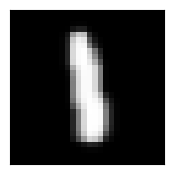

In [8]:
# Check Random Sample Image
random_index = random.randint(0,len(emnist["train"]))
random_sample = emnist['train'][random_index]
random_image = random_sample['image']
random_label = random_sample['label']
try:
  random_label = ORIGINAL_TO_NEW[random_label]
except:
  # Not part of our character set
  random_label = None
view_image(random_image, random_label)

# 3. Pre-process Data
* Filter by Target Characters
* Create Strikethrough Images
* Combine Data
* One Hot Encode Labels
* Normalize Images
* Create Dataset for Training
* Create Augmented Dataset for Training

## Filter Data

In [9]:
# Manually Filter Dataset
filtered_train_images = []
filtered_train_labels = []
filtered_test_images = []
filtered_test_labels = []

for sample in emnist['train']:
  image = sample['image']
  label = sample['label']
  if label in ORIGINAL_LABELS:
      filtered_train_images.append(image)
      filtered_train_labels.append(ORIGINAL_TO_NEW[label])

for sample in emnist['test']:
  image = sample['image']
  label = sample['label']
  if label in ORIGINAL_LABELS:
      filtered_test_images.append(image)
      filtered_test_labels.append(ORIGINAL_TO_NEW[label])

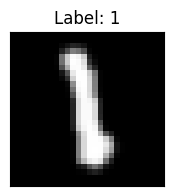

In [10]:
# Check Random Sample Image
random_index = random.randint(0,len(filtered_train_images))
random_image = filtered_train_images[random_index]
random_label = filtered_train_labels[random_index]
view_image(random_image, random_label)

## Create Strikethrough Data

In [11]:
# Create Strikthrough Data
if STRIKETHROUGH_ON:
  # Create Strikethrough Images and Labels
  strikethrough_train_images, strikethrough_train_labels = strikethrough_image_arrays(filtered_train_images, filtered_train_labels)
  strikethrough_test_images, strikethrough_test_labels = strikethrough_image_arrays(filtered_test_images, filtered_test_labels)

In [12]:
# Combine Target and Strikethrough Data
if STRIKETHROUGH_ON:
  train_images = filtered_train_images + strikethrough_train_images
  train_labels = filtered_train_labels + strikethrough_train_labels
  test_images = filtered_test_images + strikethrough_test_images
  test_labels = filtered_test_labels + strikethrough_test_labels
else:
  # Target Data
  train_images = filtered_train_images
  train_labels = filtered_train_labels
  test_images = filtered_test_images
  test_labels = filtered_test_labels

# Check sizes
len(train_images), len(train_labels), len(test_images), len(test_labels)

(445653, 445653, 74758, 74758)

## Data Augmentation

In [13]:
# Normalize Images
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0

In [14]:
# ImageDataGenerator for Augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=5,
                             zoom_range=0.1,
                             fill_mode='constant',
                             cval=0)

# Fit datagen
datagen.fit(train_images)

# Genereate augmented images
augmented_train_images, augmented_train_labels = next(datagen.flow(train_images, train_labels, batch_size=len(train_images)))

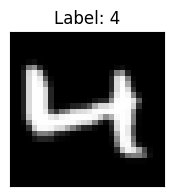

In [15]:
# Check Random Sample Image
random_index = random.randint(0,len(train_images))
random_image = train_images[random_index]
random_label = train_labels[random_index]
view_image(random_image, random_label)

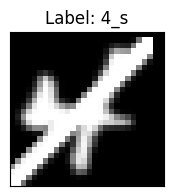

In [16]:
# Check Random Augmented Sample Image
random_index = random.randint(0,len(augmented_train_images))
random_image = augmented_train_images[random_index]
random_label = augmented_train_labels[random_index]
view_image(random_image, random_label)

## One Hot Encode Labels

In [17]:
# One Hot Encode Labels
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Reshape Labels to Numpy Arrays
reshaped_train_labels = np.array(train_labels).reshape(-1, 1)
reshaped_test_labels = np.array(test_labels).reshape(-1, 1)
reshaped_augmented_train_labels = np.array(augmented_train_labels).reshape(-1, 1)

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
augmented_encoder = OneHotEncoder(sparse_output=False)

# Fit and Transform Labels
one_hot_train_labels = encoder.fit_transform(reshaped_train_labels)
one_hot_test_labels = encoder.transform(reshaped_test_labels)
one_hot_augmented_train_labels = augmented_encoder.fit_transform(reshaped_augmented_train_labels)

In [18]:
# Dataset Constants
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Create dataset, batch, prefetch, and autotune
train_ds = tf.data.Dataset.from_tensor_slices((train_images, one_hot_train_labels)).shuffle(10000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, one_hot_test_labels)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
augmented_train_ds = tf.data.Dataset.from_tensor_slices((augmented_train_images, one_hot_augmented_train_labels)).shuffle(10000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Check datasets
print(train_ds)
print(test_ds)
print(augmented_train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 17), dtype=tf.float64, name=None))>


# 4. View Samples

* Display Sample Grid

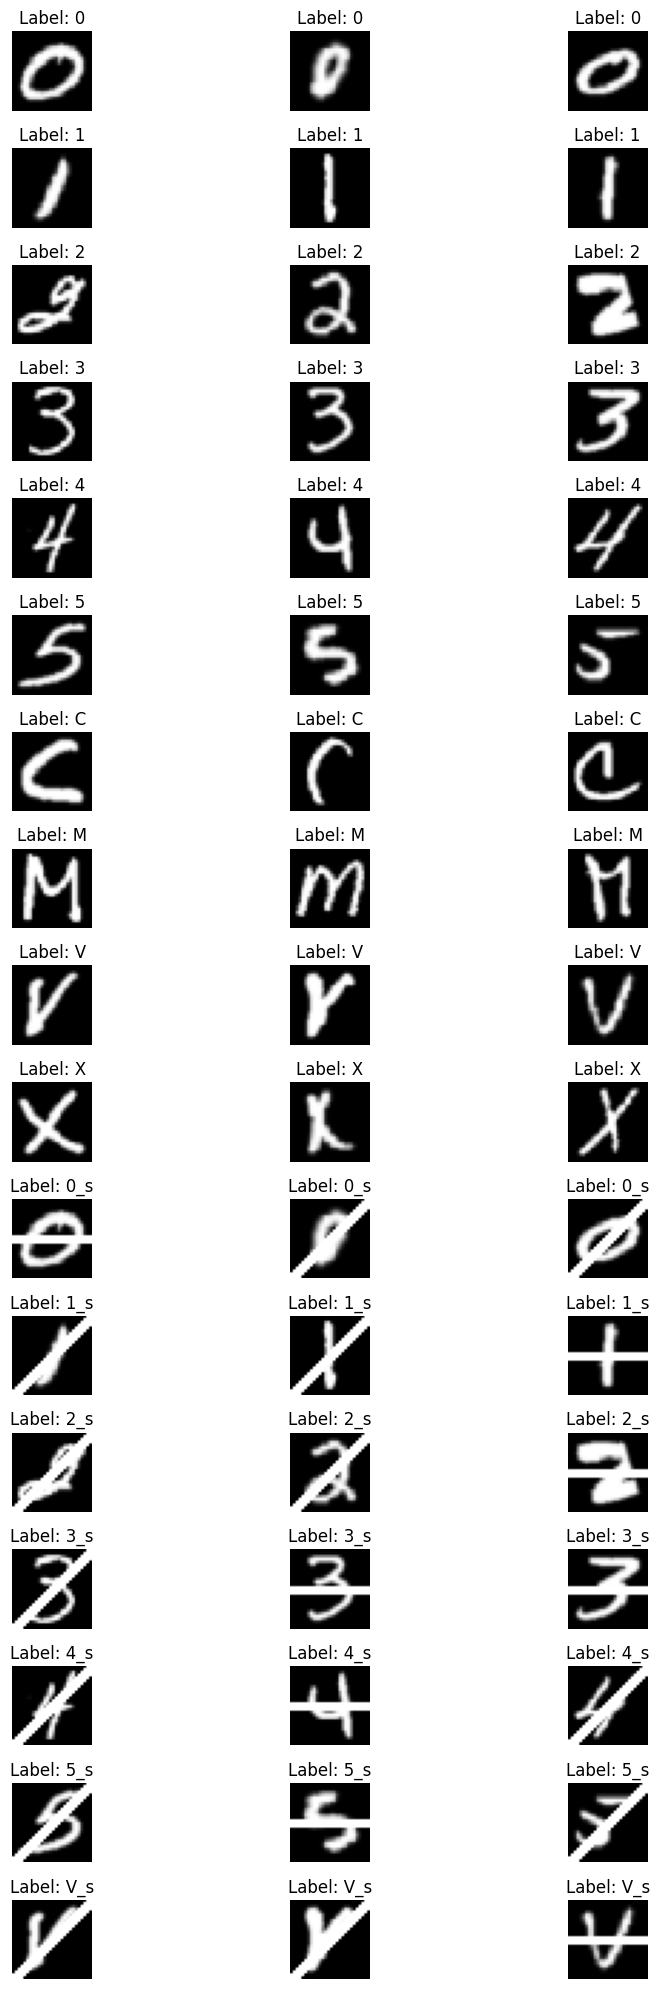

In [19]:
# Gather Samples Images and Indexes
indexes = []
for char in CLASSES:
  count = 0
  index = 0
  for label in train_labels:
    if CLASSES[label] == char:
      indexes.append(index)
      count += 1
      if count == 3:
        break
    index += 1

# Display Sample Grid
display_grid(indexes, train_images, train_labels, num_cols=3)

# 5. Model Experiments

In [20]:
# Define constants
INPUT_SIZE = (28, 28, 1)
EPOCHS = 15
LEARNING_RATE = 0.001

## Model 0: Baseline

In [21]:
if RUN_EXPERIMENTS == True:
  # Set random seed
  tf.random.set_seed(42)

  # Create Model
  model_0 = Sequential()
  model_0.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SIZE))
  model_0.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model_0.add(Flatten())
  model_0.add(Dense(NUM_CLASSES, activation='softmax'))

  # Compile Model
  model_0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit Model
  history_0 = model_0.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Epoch 1/15
13927/13927 [==============================] - 48s 3ms/step - loss: 0.0480 - accuracy: 0.9862 - val_loss: 0.1385 - val_accuracy: 0.9496
Epoch 2/15
13927/13927 [==============================] - 45s 3ms/step - loss: 0.0221 - accuracy: 0.9937 - val_loss: 0.0381 - val_accuracy: 0.9886
Epoch 3/15
13927/13927 [==============================] - 44s 3ms/step - loss: 0.0140 - accuracy: 0.9960 - val_loss: 0.0270 - val_accuracy: 0.9930
Epoch 4/15
13927/13927 [==============================] - 44s 3ms/step - loss: 0.0098 - accuracy: 0.9971 - val_loss: 0.0283 - val_accuracy: 0.9934
Epoch 5/15
13927/13927 [==============================] - 44s 3ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0315 - val_accuracy: 0.9935
Epoch 6/15
13927/13927 [==============================] - 45s 3ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0341 - val_accuracy: 0.9935
Epoch 7/15
13927/13927 [==============================] - 44s 3ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0

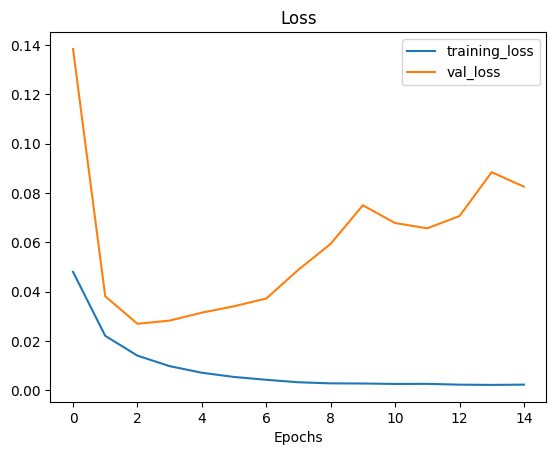

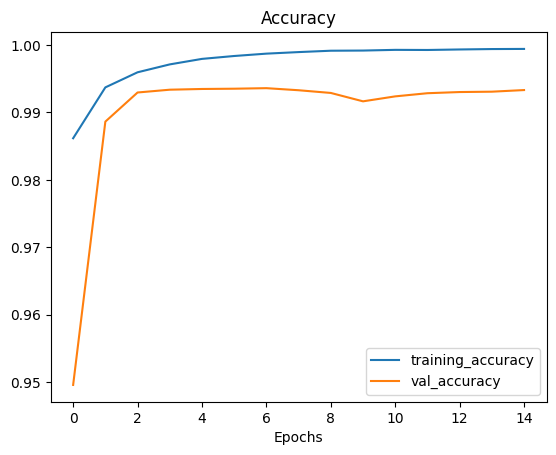

In [22]:
if RUN_EXPERIMENTS == True:
  # Model 0 Results
  plot_loss_curves(history_0)

The Baseline training accuracy and loss curves show the model is learning correctly but the validation curve do not match, so the model is overfitting.

## Model 1: Add Batch Normalization

In [ ]:
if RUN_EXPERIMENTS == True:
  # Set random seed
  tf.random.set_seed(42)

  # Create Model
  model_1 = Sequential()
  model_1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SIZE))
  model_1.add(BatchNormalization())
  model_1.add(Conv2D(32, (3, 3), activation='relu'))
  model_1.add(BatchNormalization())
  model_1.add(Flatten())
  model_1.add(Dense(NUM_CLASSES, activation='softmax'))

  # Compile Model
  model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit Model
  history_1 = model_1.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Epoch 1/15
13927/13927 [==============================] - 55s 4ms/step - loss: 0.0827 - accuracy: 0.9838 - val_loss: 0.4839 - val_accuracy: 0.8118
Epoch 2/15
13927/13927 [==============================] - 53s 4ms/step - loss: 0.0243 - accuracy: 0.9931 - val_loss: 0.0829 - val_accuracy: 0.9715
Epoch 3/15
13927/13927 [==============================] - 53s 4ms/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 0.0355 - val_accuracy: 0.9901
Epoch 4/15
13927/13927 [==============================] - 53s 4ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0416 - val_accuracy: 0.9892
Epoch 5/15
13927/13927 [==============================] - 53s 4ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 0.0308 - val_accuracy: 0.9937
Epoch 6/15
13927/13927 [==============================] - 53s 4ms/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0.0374 - val_accuracy: 0.9925
Epoch 7/15
13927/13927 [==============================] - 53s 4ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0

In [ ]:
if RUN_EXPERIMENTS == True:
  # Model 1 Results
  plot_loss_curves(history_1)

This shows better validaton curve but is still insufficient.

## Model 2: Add Dropout

In [ ]:
if RUN_EXPERIMENTS == True:
  # Set random seed
  tf.random.set_seed(42)

  # Create Model
  model_2 = Sequential()
  model_2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SIZE))
  model_2.add(BatchNormalization())
  model_2.add(Dropout(0.5))
  model_2.add(Conv2D(64, kernel_size = 3, activation='relu'))
  model_2.add(BatchNormalization())
  model_2.add(Dropout(0.5))
  model_2.add(Flatten())
  model_2.add(Dense(NUM_CLASSES, activation='softmax'))

  # Compile Model
  model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit Model
  history_2 = model_2.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

In [ ]:
if RUN_EXPERIMENTS == True:
  # Model 2 Results
  plot_loss_curves(history_2)

We're getting a better curve here. Let's add some more dropout.

## Model 3: Further Dropout

In [ ]:
if RUN_EXPERIMENTS == True:
  # Set random seed
  tf.random.set_seed(42)

  # Create Model
  model_3 = Sequential()
  model_3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SIZE))
  model_3.add(BatchNormalization())
  model_3.add(Dropout(0.3))
  model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model_3.add(BatchNormalization())
  model_3.add(Dropout(0.3))
  model_3.add(Flatten())
  model_3.add(Dense(128, activation='relu'))
  model_3.add(Dropout(0.5))
  model_3.add(Dense(NUM_CLASSES, activation='softmax'))

  # Compile Model
  model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit Model
  history_3 = model_3.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

In [ ]:
if RUN_EXPERIMENTS == True:
  # Model 3 Results
  plot_loss_curves(history_3)

This is our best yet, let's test a little more complexity.

## Model 4: Add Complexity

In [ ]:
if RUN_EXPERIMENTS == True:
  # Set random seed
  tf.random.set_seed(42)

  # Create Model
  model_4 = Sequential()
  model_4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SIZE))
  model_4.add(BatchNormalization())
  model_4.add(Dropout(0.3))
  model_4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model_4.add(BatchNormalization())
  model_4.add(Dropout(0.3))
  model_4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model_4.add(BatchNormalization())
  model_4.add(Dropout(0.3))
  model_4.add(Flatten())
  model_4.add(Dense(128, activation='relu'))
  model_4.add(Dropout(0.5))
  model_4.add(Dense(NUM_CLASSES, activation='softmax'))

  # Compile Model
  model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit Model
  history_4 = model_4.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

In [ ]:
if RUN_EXPERIMENTS == True:
  # Model 4 Results
  plot_loss_curves(history_4)

This looks like it going well, we could potentially add some more complexity but let's try regularization first.

## Model 5: Add L2 Regularization

In [ ]:
if RUN_EXPERIMENTS == True:
  # Set random seed
  tf.random.set_seed(42)

  # Create Model
  model_5 = Sequential()
  model_5.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=INPUT_SIZE))
  model_5.add(BatchNormalization())
  model_5.add(Dropout(0.3))
  model_5.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
  model_5.add(BatchNormalization())
  model_5.add(Dropout(0.3))
  model_5.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
  model_5.add(BatchNormalization())
  model_5.add(Dropout(0.3))
  model_5.add(Flatten())
  model_5.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
  model_5.add(Dropout(0.5))
  model_5.add(Dense(NUM_CLASSES, activation='softmax'))

  # Compile Model
  model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit Model
  history_5 = model_5.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

In [ ]:
if RUN_EXPERIMENTS == True:
  # Model 5 Results
  plot_loss_curves(history_5)

This does seem to make the validation results more erratic but the val_loss is the best yet.

We'll use this for our final model and include a slower learning rate for better coverging, EarlyStopping to let our model run until it stops learning and use the Augmented Data we created earlier.

# 6. Model (Final Selection)

Our final model follows the model structure of Model 5 with the following adjustments:
* Slower Larning Rate: Reduced rate of 0.0005 so training/test coverges slower.
* EarlyStopping: Stop training if validation loss increases.
* Data Augmentation: Training on augmented data to mimic real world data.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.0001), input_shape=INPUT_SIZE))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit Model
history = model.fit(augmented_train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping])

# 7. Results

In [ ]:
# Make Predictions vs True Labels
y_preds = model.predict(test_images)
y_preds = np.argmax(y_preds, axis=1)
y_true = [np.argmax(label) for label in one_hot_test_labels]

In [ ]:
## Accuracy/Loss Curves
plot_loss_curves(history)

In [ ]:
# Confusion Matrix
make_confusion_matrix(y_true=y_true, y_pred=y_preds, classes=CLASSES, figsize=(15, 15), text_size=10)